In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pickle as pkl
from descartes import PolygonPatch

import requests
import pandas as pd
import feedparser
from bs4 import BeautifulSoup
import urllib.request
import urllib3
import json
from pandas.io.json import json_normalize
import numpy as np

In [2]:
crs = {'init': 'epsg:4326'}
turl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/City_Boundary/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
bdry = gpd.read_file(turl)
bdry.dtypes

OBJECTID               int64
CityName              object
Shape_STArea__       float64
Shape_STLength__     float64
Shape__Area          float64
Shape__Length        float64
geometry            geometry
dtype: object

In [236]:
def buffer_mi(df, miles):
    """takes geopandas dataframe and returns a buffer of miles from that point/polygon
    Args:
        df (geopandas dataframe) - geopandas dataframe to convert
        mile - number of miles that buffer is from points in geometry  
    Returns:
        convertedDF - new geopandas dataframe that has a polygon that is m miles buffer from original geometry
    """
    #Getting mile buffer for the outside of Tempe
    convertedDF = df.to_crs({'init': 'epsg:3174'})
    
    #converting from miles to meters
    buffer_length_in_meters = (miles * 1000) * 1.60934
    convertedDF['geometry'] = convertedDF.geometry.buffer(buffer_length_in_meters)

    convertedDF = convertedDF.to_crs({'init': 'epsg:4326'})
    
    convertedDF.reset_index(inplace=True)
    convertedDF.drop(['index'], axis=1, inplace=True)
    return(convertedDF)

In [237]:
bndryConvertedB = buffer_mi(bdry, 2)

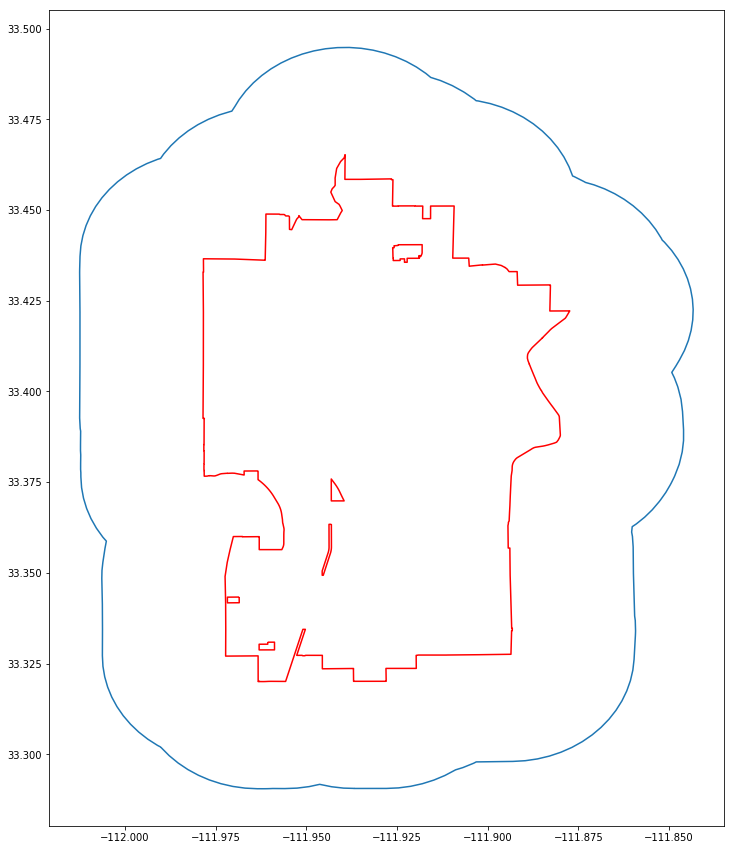

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
bndryConvertedB.boundary.plot(ax=ax)
bdry.boundary.plot(ax=ax, color='red')

In [224]:
#Pulling Tempe census data from feature layer
tempe = gpd.read_file("https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Map/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=")


# Medical Facilities in Maricopa County

In [225]:
def create_geo_df_mf(url, layer):
    """takes url and returns geopandas dataframe used for the Medical facilities.
    Args:
        url - queried from ArcGIS
        layer - name of the feature layer data was pulled from
    Returns:
        geo_df - new geopandas dataframe from that url
    """
    resp = requests.get(url)
    data_raw = resp.json()

    medF_data = pd.io.json.json_normalize(data_raw['features'])
    desired_cols = ['attributes.Name','attributes.TYPE',
                    'attributes.SUBTYPE','attributes.Icon_Category',
                   'attributes.Capacity','attributes.P_Address','attributes.P_city','attributes.P_county',
                   'attributes.P_zip','attributes.N_LAT',
                   'attributes.N_LON']

    medF_df = medF_data[desired_cols]

    medF_df.columns =['Name','Type','Subtype','Category','Capacity','Address','City','County',
                    'Zip','Lat','Lon']
    medF_df['Layer'] = layer
    
    crs = {'init': 'epsg:4326'}
    tempe_med = pd.DataFrame(medF_df)

    geometry = [Point(xy) for xy in zip(tempe_med['Lon'],tempe_med['Lat'])]

    geo_df = gpd.GeoDataFrame(tempe_med, crs = crs, geometry = geometry)
    
    return(geo_df)

In [238]:
def facility_within_tempebuffer(geo_df, tempebuffer):
    """takes geopandas dataframe and returns the points that are within the Tempe buffer
    Args:
        geo_df (geopandas dataframe) - geopandas dataframe to pull points from
        tempebuffer - geopandas dataframe made of the Tempe city mile buffer
    Returns:
        df_mi - new geopandas dataframe that the points within the Tempe buffer
    """
    df_mi = pd.DataFrame()
    for i in range(len(tempebuffer)):
        df = geo_df[geo_df.within(tempebuffer.loc[i,'geometry'])]
        df_mi = df_mi.append(df)
    df_mi.reset_index(inplace=True)
    df_mi.drop(['index'], axis=1, inplace=True)
    return(df_mi)

### Hospitals

In [227]:
url ='https://services1.arcgis.com/mpVYz37anSdrK4d8/ArcGIS/rest/services/AZLicensedFacilities/FeatureServer/0/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='
geo_hm = create_geo_df_mf(url, 'Hospital')
geo_hm.head()

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Name      Type  \
0            ST JOSEPH'S HOSPITAL AND MEDICAL CENTER  HOSPITAL   
1                         PHOENIX CHILDRENS HOSPITAL  HOSPITAL   
2  ENCOMPASS HEALTH REHABILITATION HOSPITAL OF EA...  HOSPITAL   
3                               MAYO CLINIC HOSPITAL  HOSPITAL   
4                         ARIZONA SPECIALTY HOSPITAL  HOSPITAL   

               Subtype  Category  Capacity                           Address  \
0  TRANSPLANT HOSPITAL  HOSPITAL         0  350 WEST THOMAS ROAD, SUITE #500   
1  TRANSPLANT HOSPITAL  HOSPITAL         0             1919 EAST THOMAS ROAD   
2       REHABILITATION  HOSPITAL        60           5652 EAST BASELINE ROAD   
3  TRANSPLANT HOSPITAL  HOSPITAL         0          5777 EAST MAYO BOULEVARD   
4           SHORT TERM  HOSPITAL        24    2905 WEST WARNER ROAD, SUITE 1   

       City    County    Zip        Lat         Lon     Layer  \
0   PHOENIX  MARICOPA  85013  33.480432 -112.079297  Hospital   
1   PHOENIX  MARICOPA  85016  33.480082 -112.041025  Hospital   
2      MESA  MARICOPA  85206  33.379473 -111.710331  Hospital   
3   PHOENIX  MARICOPA  85054  33.663173 -111.955677  Hospital   
4  CHANDLER  MARICOPA  85224  33.334700 -111.891218  Hospital   

                      geometry  
0  POINT (-112.07930 33.48043)  
1  POINT (-112.04103 33.48008)  
2  POINT (-111.71033 33.37947)  
3  POINT (-111.95568 33.66317)  
4  POINT (-111.89122 33.33470)

In [239]:
hospitals_2mi = facility_within_tempebuffer(geo_hm, bndryConvertedB)
hospitals_2mi.head()

Name      Type      Subtype  Category  \
0         ARIZONA SPECIALTY HOSPITAL  HOSPITAL   SHORT TERM  HOSPITAL   
1       BANNER DESERT MEDICAL CENTER  HOSPITAL   SHORT TERM  HOSPITAL   
2   SCOTTSDALE OSBORN MEDICAL CENTER  HOSPITAL   SHORT TERM  HOSPITAL   
3  BANNER BEHAVIORAL HEALTH HOSPITAL  HOSPITAL  PSYCHIATRIC  HOSPITAL   
4                O.A.S.I.S. HOSPITAL  HOSPITAL   SHORT TERM  HOSPITAL   

   Capacity                         Address        City    County    Zip  \
0        24  2905 WEST WARNER ROAD, SUITE 1    CHANDLER  MARICOPA  85224   
1       615         1400 SOUTH  DOBSON ROAD        MESA  MARICOPA  85202   
2       341           7400 EAST OSBORN ROAD  SCOTTSDALE  MARICOPA  85251   
3       156           7575 EAST EARLL DRIVE  SCOTTSDALE  MARICOPA  85251   
4        64           750 NORTH 40TH STREET     PHOENIX  MARICOPA  85008   

         Lat         Lon     Layer                     geometry  
0  33.334700 -111.891218  Hospital  POINT (-111.89122 33.33470)  
1  33.390773 -111.874786  Hospital  POINT (-111.87479 33.39077)  
2  33.487776 -111.922888  Hospital  POINT (-111.92289 33.48778)  
3  33.483854 -111.918339  Hospital  POINT (-111.91834 33.48385)  
4  33.456559 -111.995377  Hospital  POINT (-111.99538 33.45656)

**THIS PART IS TO MAKE SURE THE WAY TO GET THE POINT(of the facility) BUFFER AND COUNT OF FACILITIES WITHIN 2 MI OF THE CENTROID(of the census tract)

the count is created by counting the number of facility buffer polygons (a 2 mile ring from the facility location) that contain the centroid of the census tract.


In [240]:
#Testing to make sure this way works
hConvertedB = buffer_mi(hospitals_2mi, 2)

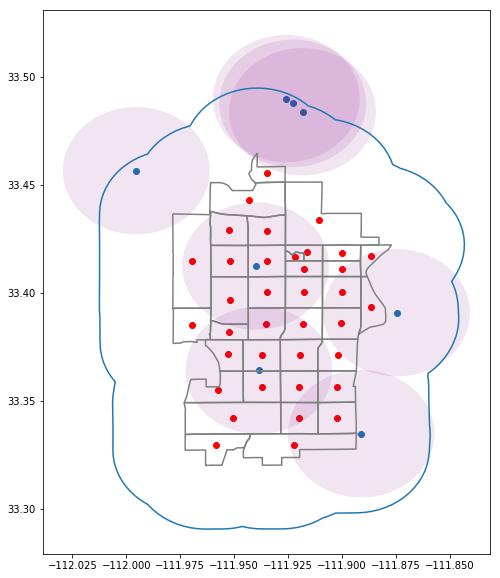

In [241]:
fig, ax = plt.subplots(figsize=(10,10))
bndryConvertedB.boundary.plot(ax=ax)
#bdry.boundary.plot(ax=ax, color='black')
hospitals_2mi.plot(ax=ax)
tempe.boundary.plot(ax=ax,color='grey')
tempe.centroid.plot(ax=ax, color='red')
hConvertedB.plot(ax=ax, color='purple',alpha=0.1)

In [242]:
from osgeo import ogr

medFacCendf = pd.DataFrame()
counts = {}
hByCen = {}
#print(hConvertedB.dtypes)
for i in range(len(tempe)):
    loc1 = tempe.loc[i,'geometry'].centroid
    name = tempe.loc[i, 'TempeTracts_NAME']
    #print(name)
    hCount = 0
    hList = []
    for j in range(len(hConvertedB)):
        loc2 = hConvertedB.loc[j,'geometry']
        hname = hConvertedB.loc[j, 'Name']
        intersection = loc1.within(loc2)
        if intersection == True:
            hCount += 1
            hList.append(hname)
        if j == 7:
            df = pd.DataFrame()
            counts[name] = hCount
            hByCen[name] = hList


print(counts)
#print(hByCen)




{'3188': 1, '3191.01': 1, '3189': 1, '3190': 1, '3194.03': 1, '3197.03': 0, '3194.04': 1, '3195': 1, '3197.04': 1, '3196': 1, '3191.03': 1, '3191.04': 1, '3192.01': 0, '3192.02': 0, '3197.05': 1, '3197.06': 1, '3201': 0, '8100': 0, '8101': 1, '3198': 2, '3199.02': 1, '3199.03': 1, '3199.04': 0, '3199.05': 1, '3199.06': 1, '3199.10': 1, '3200.01': 1, '3199.08': 1, '3199.09': 1, '3200.07': 1, '3184': 0, '3187': 1, '3193': 1, '3194.01': 1, '3194.02': 1, '3199.07': 2, '3185.01': 0}


### Long-Term Care

In [284]:
#LongTerm Care
url = 'https://services1.arcgis.com/mpVYz37anSdrK4d8/ArcGIS/rest/services/AZLicensedFacilities/FeatureServer/1/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='

geo_lt = create_geo_df_mf(url,'LongTerm')

geo_lt

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Name  \
0                                     SUN VALLEY LODGE   
1                SHEA POST ACUTE REHABILITATION CENTER   
2                               MI CASA NURSING CENTER   
3                            SCOTTSDALE VILLAGE SQUARE   
4                   LIFE CARE CENTER OF NORTH GLENDALE   
5                 PUEBLO NORTE SENIOR LIVING COMMUNITY   
6                          PHOENIX MOUNTAIN POST ACUTE   
7               SUNVIEW RESPIRATORY AND REHABILITATION   
8                                     PLAZA HEALTHCARE   
9                WELLSPRINGS THERAPY CENTER OF GILBERT   
10       LA ESTANCIA NURSING AND REHABILITATION CENTER   
11                                    HAVEN OF PHOENIX   
12                    OSBORN HEALTH AND REHABILITATION   
13                         FRIENDSHIP VILLAGE OF TEMPE   
14                    ADVANCED HEALTH CARE OF GLENDALE   
15                           THE GARDENS OF SCOTTSDALE   
16                                ACACIA HEALTH CENTER   
17     MESA CHRISTIAN HEALTH AND REHABILITATION CENTER   
18   MISSION PALMS OF MESA HEALTH AND REHABILITATIO...   
19                    DESERT TERRACE HEALTHCARE CENTER   
20                          CORONADO HEALTHCARE CENTER   
21                          DESERT COVE NURSING CENTER   
22                        PALM VALLEY REHAB & CARE CTR   
23              CHANDLER POST ACUTE AND REHABILITATION   
24                         ADVANCED HEALTHCARE OF MESA   
25                            CENTER AT ARROWHEAD, LLC   
26                   ADVANCE HEALTH CARE OF SCOTTSDALE   
27             CAMELBACK POST ACUTE AND REHABILITATION   
28                                        SIERRA WINDS   
29                            DESERT HAVEN CARE CENTER   
..                                                 ...   
71                                       ATP - WINDSOR   
72                                         ATP - EARLL   
73                 ALTA MESA HEALTH AND REHABILITATION   
74             HERITAGE COURT POST ACUTE OF SCOTTSDALE   
75                        THE CENTER AT VAL VISTA, LLC   
76                             HACIENDA DE LOS ANGELES   
77                      WEYRICH HCC OF WESTMINSTER VLG   
78   VI AT SILVERSTONE, A VI AND PLAZA COMPANIES CO...   
79           SUN CITY HEALTH AND REHABILITATION CENTER   
80                             LIFESTREAM AT SUN RIDGE   
81                                      ATP - CAMPBELL   
82                                      ATP - CAMPBELL   
83                             WESTCHESTER CARE CENTER   
84               WELLSPRINGS THERAPY CENTER OF PHOENIX   
85                         FORUM AT DESERT HARBOR, THE   
86                  SUN WEST CHOICE HEALTHCARE & REHAB   
87                PEORIA POST ACUTE AND REHABILITATION   
88                               FOUNTAIN VIEW VILLAGE   
89                               FOUNTAIN VIEW VILLAGE   
90                DESERT BLOSSOM HEALTH & REHAB CENTER   
91                      SUN HEALTH LA LOMA CARE CENTER   
92                      SUN HEALTH LA LOMA CARE CENTER   
93                        ALLEGIANT HEALTHCARE OF MESA   
94                           SOUTH MOUNTAIN POST ACUTE   
95                                NORTH CHANDLER PLACE   
96                      LIFE CARE CENTER OF SCOTTSDALE   
97                      LIFE CARE CENTER OF SCOTTSDALE   
98                                   SANTE OF SURPRISE   
99                                   SANTE OF SURPRISE   
100        BELLA VITA HEALTH AND REHABILITATION CENTER   

                                                  Type              Subtype  \
0                                    NURSING HOME (NH)  STATE ONLY FACILITY   
1                                    NURSING HOME (NH)     SNF/NF DUAL CERT   
2                                    NURSING HOME (NH)     SNF/NF DUAL CERT   
3                                    NURSING HOME (NH)     SNF/NF DUAL CERT   
4                                    NURSING HOME (NH)    

In [285]:
longterm_2mi = facility_within_tempebuffer(geo_lt, bndryConvertedB)
len(longterm_2mi)

11

### Medical Facilities

In [246]:
#Medical Facilities
url = 'https://services1.arcgis.com/mpVYz37anSdrK4d8/ArcGIS/rest/services/AZLicensedFacilities/FeatureServer/2/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryPoint&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=102100&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='

geo_mf = create_geo_df_mf(url, 'MedFac')

geo_mf.head()

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Name                                  Type  \
0  BAYLESS HEALTHCARE GROUP                 AZ MEDICAL FACILITIES   
1    INTEGRO HEALTH SYSTEMS  Behavioral Health Inpatient Facility   
2    INTEGRO HEALTH SYSTEMS                 AZ MEDICAL FACILITIES   
3  BAYLESS HEALTHCARE GROUP                 AZ MEDICAL FACILITIES   
4             NATIVE HEALTH                 AZ MEDICAL FACILITIES   

                       Subtype      Category  Capacity  \
0  OUTPATIENT TREATMENT CENTER           OTC         0   
1             INPT BH SUBACUTE  BH Inpatient        16   
2  OUTPATIENT TREATMENT CENTER           OTC        15   
3  OUTPATIENT TREATMENT CENTER           OTC         0   
4  OUTPATIENT TREATMENT CENTER           OTC         0   

                                           Address     City    County    Zip  \
0                2204 SOUTH DOBSON ROAD, SUITE 102     MESA  MARICOPA  85202   
1           1501 EAST ORANGEWOOD AVENUE BUILDING A  PHOENIX  MARICOPA  85020   
2                      1501 EAST ORANGEWOOD AVENUE  PHOENIX  MARICOPA  85020   
3                 2204 SOUTH DOBSON ROAD SUITE 201     MESA  MARICOPA  85202   
4  777 WEST SOUTHERN AVENUE, BUILDING E, SUITE 501     MESA  MARICOPA  85210   

         Lat         Lon   Layer                     geometry  
0  33.374945 -111.879873  MedFac  POINT (-111.87987 33.37494)  
1  33.545327 -112.049316  MedFac  POINT (-112.04932 33.54533)  
2  33.545327 -112.049316  MedFac  POINT (-112.04932 33.54533)  
3  33.374945 -111.879873  MedFac  POINT (-111.87987 33.37494)  
4  33.393001 -111.848395  MedFac  POINT (-111.84839 33.39300)

In [247]:
med_2mi = facility_within_tempebuffer(geo_mf, bndryConvertedB)
len(med_2mi)

131

### DUI/Domestic Violence

In [248]:
#DUI/Domestic Violence
url='https://services1.arcgis.com/mpVYz37anSdrK4d8/ArcGIS/rest/services/AZLicensedFacilities/FeatureServer/7/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='

geo_dui = create_geo_df_mf(url, 'DUI/DV')

geo_dui.head()

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Name                       Type  \
0  CONFIDENTIAL COUNSELING & CONSULTING LLC  SL-Court Ordered Services   
1     INTUITIVE HEALING COUNSELING SERVICES  SL-Court Ordered Services   
2                      RECLAIM U COUNSELING  SL-Court Ordered Services   
3             RAYIOM HEALTH & WELLNESS, INC  SL-Court Ordered Services   
4     BRIDGING THE HOPE COUNSELING SERVICES  SL-Court Ordered Services   

    Subtype     Category  Capacity  \
0  DUI/DVTX  MED - Other         0   
1  DUI/DVTX  MED - Other         0   
2  DUI/DVTX  MED - Other         0   
3  DUI/DVTX  MED - Other         0   
4  DUI/DVTX  MED - Other         0   

                                      Address     City    County    Zip  \
0                  4625 SOUTH LAKESHORE DRIVE    TEMPE  MARICOPA  85282   
1  3303 EAST BASELINE ROAD, BLDG 5, SUITE 109  GILBERT  MARICOPA  85234   
2         2111  EAST BASELINE ROAD, SUITE B-3    TEMPE  MARICOPA  85283   
3               2390 EAST CAMELBACK ROAD #130  PHOENIX  MARICOPA  85016   
4                           5320 N16TH STREET  PHOENIX  MARICOPA  85016   

         Lat         Lon   Layer                     geometry  
0  33.381618 -111.924170  DUI/DV  POINT (-111.92417 33.38162)  
1  33.378917 -111.762337  DUI/DV  POINT (-111.76234 33.37892)  
2  33.378312 -111.896908  DUI/DV  POINT (-111.89691 33.37831)  
3  33.509528 -112.031561  DUI/DV  POINT (-112.03156 33.50953)  
4  33.514953 -112.047691  DUI/DV  POINT (-112.04769 33.51495)

In [249]:
dui_2mi = facility_within_tempebuffer(geo_dui, bndryConvertedB)
len(dui_2mi)

4

### All Medical Facilities 

In [253]:
facilities_2mi = pd.concat([hospitals_2mi,longterm_2mi, med_2mi, dui_2mi],axis=0,
                       ignore_index=True,sort=False)
facilities_2mi.head()

Name      Type      Subtype  Category  \
0         ARIZONA SPECIALTY HOSPITAL  HOSPITAL   SHORT TERM  HOSPITAL   
1       BANNER DESERT MEDICAL CENTER  HOSPITAL   SHORT TERM  HOSPITAL   
2   SCOTTSDALE OSBORN MEDICAL CENTER  HOSPITAL   SHORT TERM  HOSPITAL   
3  BANNER BEHAVIORAL HEALTH HOSPITAL  HOSPITAL  PSYCHIATRIC  HOSPITAL   
4                O.A.S.I.S. HOSPITAL  HOSPITAL   SHORT TERM  HOSPITAL   

   Capacity                         Address        City    County    Zip  \
0        24  2905 WEST WARNER ROAD, SUITE 1    CHANDLER  MARICOPA  85224   
1       615         1400 SOUTH  DOBSON ROAD        MESA  MARICOPA  85202   
2       341           7400 EAST OSBORN ROAD  SCOTTSDALE  MARICOPA  85251   
3       156           7575 EAST EARLL DRIVE  SCOTTSDALE  MARICOPA  85251   
4        64           750 NORTH 40TH STREET     PHOENIX  MARICOPA  85008   

         Lat         Lon     Layer                     geometry  
0  33.334700 -111.891218  Hospital  POINT (-111.89122 33.33470)  
1  33.390773 -111.874786  Hospital  POINT (-111.87479 33.39077)  
2  33.487776 -111.922888  Hospital  POINT (-111.92289 33.48778)  
3  33.483854 -111.918339  Hospital  POINT (-111.91834 33.48385)  
4  33.456559 -111.995377  Hospital  POINT (-111.99538 33.45656)

In [251]:
facConvertedB = buffer_mi(facilities_2mi, 2)
facConvertedB.head()

Name      Type      Subtype  Category  \
0         ARIZONA SPECIALTY HOSPITAL  HOSPITAL   SHORT TERM  HOSPITAL   
1       BANNER DESERT MEDICAL CENTER  HOSPITAL   SHORT TERM  HOSPITAL   
2   SCOTTSDALE OSBORN MEDICAL CENTER  HOSPITAL   SHORT TERM  HOSPITAL   
3  BANNER BEHAVIORAL HEALTH HOSPITAL  HOSPITAL  PSYCHIATRIC  HOSPITAL   
4                O.A.S.I.S. HOSPITAL  HOSPITAL   SHORT TERM  HOSPITAL   

   Capacity                         Address        City    County    Zip  \
0        24  2905 WEST WARNER ROAD, SUITE 1    CHANDLER  MARICOPA  85224   
1       615         1400 SOUTH  DOBSON ROAD        MESA  MARICOPA  85202   
2       341           7400 EAST OSBORN ROAD  SCOTTSDALE  MARICOPA  85251   
3       156           7575 EAST EARLL DRIVE  SCOTTSDALE  MARICOPA  85251   
4        64           750 NORTH 40TH STREET     PHOENIX  MARICOPA  85008   

         Lat         Lon     Layer  \
0  33.334700 -111.891218  Hospital   
1  33.390773 -111.874786  Hospital   
2  33.487776 -111.922888  Hospital   
3  33.483854 -111.918339  Hospital   
4  33.456559 -111.995377  Hospital   

                                            geometry  
0  POLYGON ((-111.85920 33.34458, -111.85824 33.3...  
1  POLYGON ((-111.84274 33.40065, -111.84178 33.3...  
2  POLYGON ((-111.89080 33.49766, -111.88984 33.4...  
3  POLYGON ((-111.88626 33.49374, -111.88529 33.4...  
4  POLYGON ((-111.96332 33.46647, -111.96235 33.4...

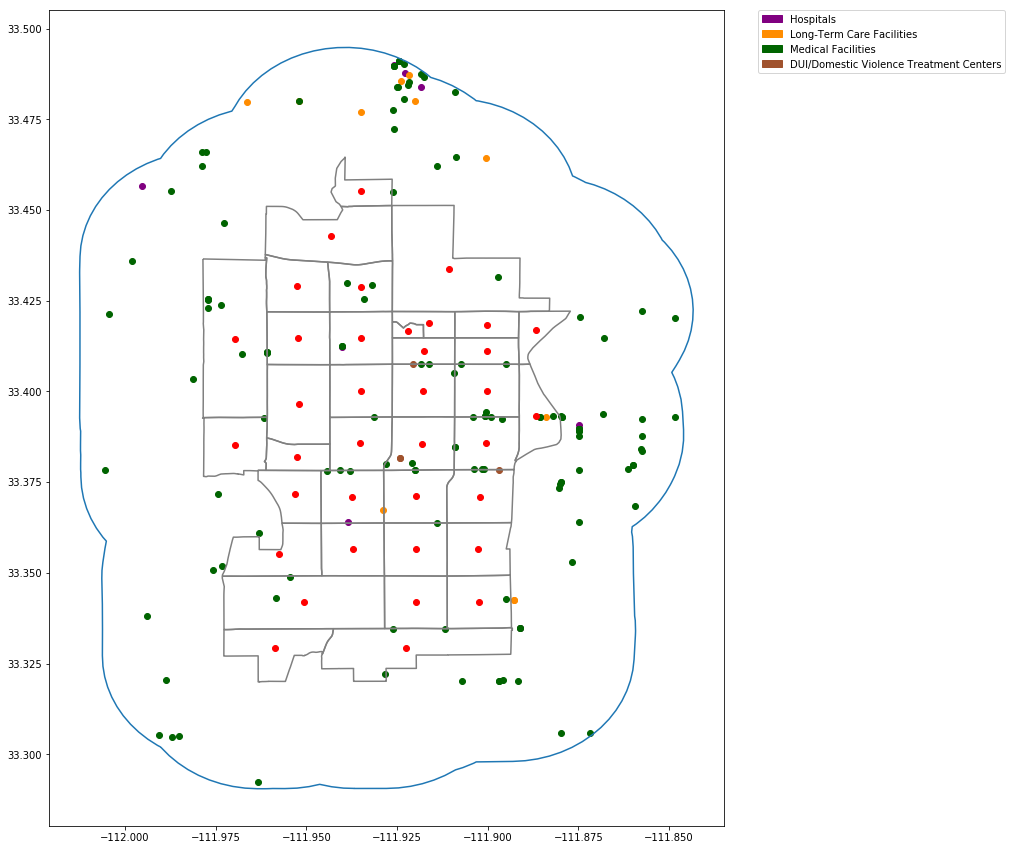

In [473]:
types = ['Hospital','Long-Term Care','Medical Facility','DUI/Domestic Violence']
colors = ['purple','darkorange','darkgreen','sienna']

import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15,15))
bndryConvertedB.boundary.plot(ax=ax)
#bdry.boundary.plot(ax=ax, color='black')
tempe.boundary.plot(ax=ax,color='grey')
tempe.centroid.plot(ax=ax, color='red')

#color coded
facilities_2mi[facilities_2mi['Layer']=='Hospital'].plot(ax=ax,color='purple')
#facConvertedB[facConvertedB['Layer']=='Hospital'].plot(ax=ax, label=str(types[i]),color='purple',alpha=0.08)
facilities_2mi[facilities_2mi['Layer']=='LongTerm'].plot(ax=ax,color='darkorange')
#facConvertedB[facConvertedB['Layer']=='LongTerm'].plot(ax=ax, label=str(types[i]),color='darkorange',alpha=0.08)
facilities_2mi[facilities_2mi['Layer']=='MedFac'].plot(ax=ax,color='darkgreen')
#facConvertedB[facConvertedB['Layer']=='MedFac'].boundary.plot(ax=ax, label=str(types[i]),color='darkgreen',alpha=0.2)
facilities_2mi[facilities_2mi['Layer']=='DUI/DV'].plot(ax=ax,color='sienna')
#facConvertedB[facConvertedB['Layer']=='DUI/DV'].plot(ax=ax, label=str(types[i]),color='sienna',alpha=0.08)


h = mpatches.Patch(color='purple',label='Hospitals')
lt = mpatches.Patch(color='darkorange',label = 'Long-Term Care Facilities')
mf = mpatches.Patch(color='darkgreen',label = 'Medical Facilities')
dui = mpatches.Patch(color = 'sienna',label = 'DUI/Domestic Violence Treatment Centers')
l2 = plt.legend(handles=[h,lt,mf,dui],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)




In [255]:
facilities_2mi['geometry2MileBuffer'] = facConvertedB['geometry']
facilities_2mi.head(1)

with open('DataFiles/medicalFacilitiesWithin2milesTempe.pkl', 'wb') as pkl_file:
    pkl.dump(facilities_2mi, pkl_file)

## Finding Counts of All Chosen Medical Facilities within m Miles from Centroid of Each Census Tract

the count is created by counting the number of facility buffer polygons (a 2 mile ring from the facility location) that contain the centroid of the census tract.

In [263]:
from osgeo import ogr
def counting_facilities(convertedDF):
    """takes geopandas dataframe and returns the points that are within the Tempe buffer
    Args:
        convertedDF (geopandas dataframe) - mile buffer geopandas dataframe to count facilities from
    Returns:
        medfCounts (lst) - list of the number of facility buffer polygons 
                            (an m mile ring from the facility location) that 
                            contain the centroid of the census tract
    """
    counts = {}
    medCounts = []
    n = len(convertedDF)-1
    for i in range(len(tempe)):
        loc1 = tempe.loc[i,'geometry'].centroid
        name = tempe.loc[i, 'TempeTracts_NAME']
        fCount = 0
        for j in range(len(convertedDF)):
            loc2 = convertedDF.loc[j,'geometry']
            intersection = loc1.within(loc2)
            if intersection == True:
                fCount += 1
            if j == n:
                counts[name] = fCount
                medCounts.append(fCount)
    print(counts)
    return(medCounts)

In [264]:
#Dataframe that will be built over time that will have the counts of medical facilities, pharmacies, and drug drop off
medFacCendf = pd.DataFrame()


In [265]:
medFacCendf['TempeTracts_Name'] = tempe['TempeTracts_NAME']
medFacCendf['MedFacilitiesCount2mi'] = counting_facilities(facConvertedB)

medFacCendf.head()

{'3188': 16, '3191.01': 16, '3189': 19, '3190': 16, '3194.03': 41, '3197.03': 11, '3194.04': 47, '3195': 32, '3197.04': 14, '3196': 27, '3191.03': 18, '3191.04': 22, '3192.01': 18, '3192.02': 24, '3197.05': 17, '3197.06': 15, '3201': 5, '8100': 7, '8101': 14, '3198': 24, '3199.02': 17, '3199.03': 24, '3199.04': 36, '3199.05': 19, '3199.06': 24, '3199.10': 8, '3200.01': 11, '3199.08': 16, '3199.09': 15, '3200.07': 19, '3184': 11, '3187': 13, '3193': 29, '3194.01': 32, '3194.02': 48, '3199.07': 13, '3185.01': 12}


TempeTracts_Name  MedFacilitiesCount2mi
0             3188                     16
1          3191.01                     16
2             3189                     19
3             3190                     16
4          3194.03                     41

In [266]:
medFacCendf.dtypes

TempeTracts_Name         object
MedFacilitiesCount2mi     int64
dtype: object

## Pharmacies

In [267]:
url='https://services1.arcgis.com/mpVYz37anSdrK4d8/ArcGIS/rest/services/Pharmacies/FeatureServer/0/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='
resp = requests.get(url)
print(resp)

data_raw = resp.json()

p_data = pd.io.json.json_normalize(data_raw['features'])

desired_cols = ['attributes.Business_N','attributes.Type_',
               'attributes.SubType_',
               'attributes.City',
               'attributes.N_ZIP','attributes.N_LAT',
               'attributes.N_LON']

p_df = p_data[desired_cols]

p_df.columns =['Name','Type','Subtype','City',
                'Zip','Lat','Lon']

tempe_p = pd.DataFrame(p_df)

geometry = [Point(xy) for xy in zip(tempe_p['Lon'],tempe_p['Lat'])]


geo_p = gpd.GeoDataFrame(tempe_p, crs = crs, geometry = geometry)
geo_p.head()

<Response [200]>


Name      Type   Subtype        City  \
0                      Walgreens Drug #01272  Pharmacy     Chain     Phoenix   
1  Scottsdale Osborn Medical Center Pharmacy  Pharmacy  Hospital  Scottsdale   
2                      Walgreens Drug #16082  Pharmacy     Chain     Phoenix   
3                      Walgreens Drug #01197  Pharmacy     Chain       Tempe   
4                      Walgreens Drug #03593  Pharmacy     Chain     Phoenix   

     Zip        Lat         Lon                     geometry  
0  85031  33.494732 -112.169111  POINT (-112.16911 33.49473)  
1  85251  33.487776 -111.922888  POINT (-111.92289 33.48778)  
2  85028  33.582619 -112.013259  POINT (-112.01326 33.58262)  
3  85282  33.392813 -111.910238  POINT (-111.91024 33.39281)  
4  85023  33.611118 -112.111889  POINT (-112.11189 33.61112)

In [268]:
pharm_2mi = facility_within_tempebuffer(geo_p, bndryConvertedB)
len(pharm_2mi)

116

In [269]:
pharmConvertedB = buffer_mi(pharm_2mi, 2)

In [270]:
medFacCendf['PharmCount2mi'] = counting_facilities(pharmConvertedB)

medFacCendf.head()

{'3188': 11, '3191.01': 14, '3189': 16, '3190': 17, '3194.03': 20, '3197.03': 13, '3194.04': 19, '3195': 16, '3197.04': 17, '3196': 17, '3191.03': 13, '3191.04': 14, '3192.01': 13, '3192.02': 15, '3197.05': 18, '3197.06': 13, '3201': 3, '8100': 21, '8101': 14, '3198': 18, '3199.02': 16, '3199.03': 14, '3199.04': 9, '3199.05': 13, '3199.06': 12, '3199.10': 14, '3200.01': 14, '3199.08': 13, '3199.09': 12, '3200.07': 13, '3184': 7, '3187': 9, '3193': 13, '3194.01': 16, '3194.02': 17, '3199.07': 14, '3185.01': 5}


TempeTracts_Name  MedFacilitiesCount2mi  PharmCount2mi
0             3188                     16             11
1          3191.01                     16             14
2             3189                     19             16
3             3190                     16             17
4          3194.03                     41             20

## Drug Drop Off Locations

In [271]:
url = 'https://services1.arcgis.com/mpVYz37anSdrK4d8/arcgis/rest/services/DrugDropOffLocations/FeatureServer/0/query?where=N_COUNTY+%3D+%27MARICOPA+COUNTY%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='
resp = requests.get(url)
print(resp)

data_raw = resp.json()

dd_data = pd.io.json.json_normalize(data_raw['features'])

desired_cols = ['attributes.Location',
               'attributes.N_CITY',
               'attributes.N_ZIP','attributes.N_LAT',
               'attributes.N_LON']

dd_df = dd_data[desired_cols]

dd_df.columns =['Location','City',
                'Zip','Lat','Lon']

tempe_dd = pd.DataFrame(dd_df)

geometry = [Point(xy) for xy in zip(tempe_dd['Lon'],tempe_dd['Lat'])]


geo_dd = gpd.GeoDataFrame(tempe_dd, crs = crs, geometry = geometry)
geo_dd.head()

<Response [200]>


Location       City    Zip        Lat  \
0  Mountain Park Health Center, Maryvale    PHOENIX  85033  33.480216   
1              Buckeye Police Department    BUCKEYE  85326  33.435517   
2             Chandler Police Department   CHANDLER  85225  33.300739   
3  Chandler Police Department Substation   CHANDLER  85249  33.233931   
4            El Mirage Police Department  EL MIRAGE  85335  33.574272   

          Lon                     geometry  
0 -112.200886  POINT (-112.20089 33.48022)  
1 -112.517596  POINT (-112.51760 33.43552)  
2 -111.838065  POINT (-111.83807 33.30074)  
3 -111.770888  POINT (-111.77089 33.23393)  
4 -112.326009  POINT (-112.32601 33.57427)

In [274]:
drug_2mi = facility_within_tempebuffer(geo_dd, bndryConvertedB)
drugConvertedB = buffer_mi(drug_2mi, 2)
len(drug_2mi)

8

In [275]:
medFacCendf['DrugDropCount2mi'] = counting_facilities(drugConvertedB)

medFacCendf.head()

{'3188': 2, '3191.01': 4, '3189': 2, '3190': 3, '3194.03': 2, '3197.03': 0, '3194.04': 3, '3195': 3, '3197.04': 0, '3196': 4, '3191.03': 4, '3191.04': 4, '3192.01': 3, '3192.02': 3, '3197.05': 1, '3197.06': 0, '3201': 2, '8100': 0, '8101': 0, '3198': 2, '3199.02': 0, '3199.03': 1, '3199.04': 1, '3199.05': 0, '3199.06': 0, '3199.10': 0, '3200.01': 0, '3199.08': 0, '3199.09': 1, '3200.07': 0, '3184': 4, '3187': 4, '3193': 1, '3194.01': 1, '3194.02': 2, '3199.07': 0, '3185.01': 1}


TempeTracts_Name  MedFacilitiesCount2mi  PharmCount2mi  DrugDropCount2mi
0             3188                     16             11                 2
1          3191.01                     16             14                 4
2             3189                     19             16                 2
3             3190                     16             17                 3
4          3194.03                     41             20                 2

## Naloxone Distributors 

https://services3.arcgis.com/1pxU2hJU9ZszJDcX/ArcGIS/rest/services/PrescriptionDrugLocations/FeatureServer/0

In [493]:
url='https://services3.arcgis.com/1pxU2hJU9ZszJDcX/ArcGIS/rest/services/PrescriptionDrugLocations/FeatureServer/0/query?where=%28municipality+%3D+%27TEMPE%27%29+OR+%28municipality+%3D+%27SCOTTSDALE%27%29+OR+%28municipality+%3D+%27PHOENIX%27%29+OR+%28municipality+%3D+%27MESA%27%29+OR+%28municipality+%3D+%27CHANDLER%27%29&objectIds=&time=&geometry=&geometryType=esriGeometryPolygon&inSR=&spatialRel=esriSpatialRelIntersects&resultType=standard&distance=0.0&units=esriSRUnit_Kilometer&returnGeodetic=true&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=true&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=true&returnM=true&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token='
resp = requests.get(url)
print(resp)

data_raw = resp.json()

n_data = pd.io.json.json_normalize(data_raw['features'])

n_data.columns



<Response [200]>


Index(['attributes.CreationDate', 'attributes.Creator', 'attributes.EditDate',
       'attributes.Editor', 'attributes.GlobalID', 'attributes.OBJECTID',
       'attributes.PhoneNumber', 'attributes.PrescriptionNeeded',
       'attributes.Reviewed', 'attributes.Source', 'attributes.agencyurl',
       'attributes.comments', 'attributes.fulladdr', 'attributes.municipality',
       'attributes.name', 'attributes.operdays', 'attributes.operhours',
       'attributes.phone', 'attributes.pocemail', 'attributes.pocname',
       'attributes.pocphone', 'geometry.x', 'geometry.y'],
      dtype='object')

In [494]:
crs = {'init': 'epsg:4326'}
desired_cols = ['attributes.name',
               'attributes.fulladdr',
               'attributes.municipality','geometry.x',
               'geometry.y']

n_df = n_data[desired_cols]

n_df.columns =['Name','FullAddr',
                'City','Lat','Long']

n_df = pd.DataFrame(n_df)

#geometry = [Point(xy) for xy in zip(tempe_n['Lon'],tempe_n['Lat'])]


#geo_n = gpd.GeoDataFrame(tempe_n, crs = crs, geometry = geometry)
#geo_n.head()
n_df = n_df[n_df['City'] != 'Phoenix']
n_df.head()
np.unique(n_df['City'])

array(['CHANDLER', 'MESA', 'PHOENIX', 'Phoenix ', 'SCOTTSDALE', 'TEMPE'],
      dtype=object)

In [497]:
from geopy.geocoders import Nominatim

def naloxone_address(df, city):
    """takes dataframe and returns the latitude and longitude and makes geopandas dataframe 
    Args:
        df (dataframe) - dataframe to get addresses from
    Returns:
        geo_df - new geopandas dataframe that has the latitude and longitude of the points
    """
    new_df = pd.DataFrame()

    lats = []
    longs = []
    c_df = df[df['City'] == city]
    c_df.reset_index(inplace=True)
    c_df.drop(['index'], axis=1, inplace=True)

    if city == 'TEMPE':
        geolocator = Nominatim(user_agent="my_app", format_string="%s, Tempe Arizona")
        for i in range(len(c_df)):
            #print(c_df.loc[i,'City'])
            address = c_df.loc[i,'FullAddr']
            if address == '3303 S. RURAL':
                address = '3303 S. RURAL RD.'
            location = geolocator.geocode(address)
            #print(location)
            lat = location.latitude
            long = location.longitude
            lats.append(lat)
            longs.append(long)
        c_df['Lat'] = lats
        c_df['Long'] = longs
        new_df = c_df
    elif city == 'PHOENIX' or city == 'Phoenix ':
        geolocator = Nominatim(user_agent="my_app", format_string="%s, Phoenix Arizona")
        for i in range(len(c_df)):
            #print(c_df.loc[i,'City'])
            address = c_df.loc[i,'FullAddr']
            if address == '50 W. JEFFERSON ST., SUITE 140':
                address = '50 W. JEFFERSON ST. #140'
            if address == '4742 E. INDIAN SCHOOL':
                geolocator = Nominatim(user_agent="my_app", format_string="%s, Phoenix")
                address = '4742 E. INDIAN SCHOOL RD.'
            location = geolocator.geocode(address)
            #print(location)
            lat = location.latitude
            long = location.longitude
            lats.append(lat)
            longs.append(long)
        c_df['Lat'] = lats
        c_df['Long'] = longs
        new_df = c_df
    elif city == 'MESA':
        geolocator = Nominatim(user_agent="my_app", format_string="%s, Mesa Arizona")
        for i in range(len(c_df)):
            #print(c_df.loc[i,'City'])
            address = c_df.loc[i,'FullAddr']
            location = geolocator.geocode(address)
            if location is None:
                geolocator = Nominatim(user_agent="my_app", format_string="%s, Mesa, AZ")
                location = geolocator.geocode(address)
                #print(address)
                if location is None:
                    geolocator = Nominatim(user_agent="my_app", format_string="%s, Arizona")
                    location = geolocator.geocode(address)
                    #print(address)
            #print(location)
            lat = location.latitude
            long = location.longitude
            lats.append(lat)
            longs.append(long)
        c_df['Lat'] = lats
        c_df['Long'] = longs
        new_df = c_df
    elif city == 'SCOTTSDALE':
        geolocator = Nominatim(user_agent="my_app", format_string="%s, Scottsdale Arizona")
        for i in range(len(c_df)):
            #print(c_df.loc[i,'City'])
            address = c_df.loc[i,'FullAddr']
            if address == '14672 N FRANK LLOYD WRIGHT':
                address = '14672 N FRANK LLOYD WRIGHT BLVD'
            if address == '23215 NO PIMA RD.':
                address = '23215 N. PIMA RD.'
            #print(address)
            location = geolocator.geocode(address)
            if location is None:
                geolocator = Nominatim(user_agent="my_app", format_string="%s, Arizona")
                location = geolocator.geocode(address)
            #print(location)
            lat = location.latitude
            long = location.longitude
            lats.append(lat)
            longs.append(long)
        c_df['Lat'] = lats
        c_df['Long'] = longs
        new_df = c_df
    else:
        geolocator = Nominatim(user_agent="my_app", format_string="%s, Chandler Arizona")
        for i in range(len(c_df)):
            #print(c_df.loc[i,'City'])
            address = c_df.loc[i,'FullAddr']
            if address == '14672 N FRANK LLOYD WRIGHT':
                address = '14672 N FRANK LLOYD WRIGHT BLVD'
            if address == '23215 NO PIMA RD.':
                address = '23215 N. PIMA RD.'
            #print(address)
            location = geolocator.geocode(address)
            if location is None:
                geolocator = Nominatim(user_agent="my_app", format_string="%s, Arizona")
                location = geolocator.geocode(address)
            #print(location)
            lat = location.latitude
            long = location.longitude
            lats.append(lat)
            longs.append(long)
        c_df['Lat'] = lats
        c_df['Long'] = longs
        new_df = c_df
    geometry = [Point(xy) for xy in zip(new_df['Long'],new_df['Lat'])]
    geo_df = gpd.GeoDataFrame(new_df, crs = crs, geometry = geometry)
    return(geo_df)
                
                
                

In [467]:
geolocator = Nominatim(user_agent="my_app", format_string="%s, Scottsdale Arizona 85257")
location = geolocator.geocode('7923 E. MCDOWELL RD.')
print(location.latitude)
33.465215, -111.910179

33.4656273


In [477]:
tempen_df = naloxone_address(n_df, 'TEMPE')
tempen_df.head()

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Name            FullAddr   City        Lat        Long  \
0       Walmart    1380 W ELLIOT RD  TEMPE  33.351075 -111.960451   
1       Walmart  800 E SOUTHERN AVE  TEMPE  33.393954 -111.927870   
2       Walmart   671 E APACHE BLVD  TEMPE  33.414881 -111.917139   
3  CVS Pharmacy  1750 E BROADWAY RD  TEMPE  33.407593 -111.909937   
4  CVS Pharmacy  1424 W BASELINE RD  TEMPE  33.378930 -111.962296   

                      geometry  
0  POINT (-111.96045 33.35108)  
1  POINT (-111.92787 33.39395)  
2  POINT (-111.91714 33.41488)  
3  POINT (-111.90994 33.40759)  
4  POINT (-111.96230 33.37893)

In [478]:
phoenix_df1 = naloxone_address(n_df, "PHOENIX")
phoenix_df2 = naloxone_address(n_df, 'Phoenix ')

phoenix_df = pd.concat([phoenix_df1, phoenix_df2],axis=0,
                       ignore_index=True,sort=False)

phoenix_df.head()

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Name                FullAddr     City        Lat        Long  \
0  Walmart         2020 N 75TH AVE  PHOENIX  33.470553 -112.223178   
1  Walmart          4617 E BELL RD  PHOENIX  33.638451 -111.981796   
2  Walmart  1607 W BETHANY HOME RD  PHOENIX  33.522077 -112.092775   
3  Walmart          1825 W BELL RD  PHOENIX  33.637084 -112.098050   
4  Walmart        3721 E THOMAS RD  PHOENIX  33.478787 -112.001086   

                      geometry  
0  POINT (-112.22318 33.47055)  
1  POINT (-111.98180 33.63845)  
2  POINT (-112.09278 33.52208)  
3  POINT (-112.09805 33.63708)  
4  POINT (-112.00109 33.47879)

In [479]:
mesa_df = naloxone_address(n_df, 'MESA')
mesa_df.head()


/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Name              FullAddr  City        Lat        Long  \
0  Walmart   6131 E SOUTHERN AVE  MESA  33.391422 -111.699176   
1  Walmart       857 N DOBSON RD  MESA  33.432013 -111.865325   
2  Walmart   4505 E MCKELLIPS RD  MESA  33.449105 -111.733671   
3  Walmart  5122 E UNIVERSITY DR  MESA  33.423782 -111.720797   
4  Walmart     1916 S LINDSAY RD  MESA  33.380320 -111.772934   

                      geometry  
0  POINT (-111.69918 33.39142)  
1  POINT (-111.86532 33.43201)  
2  POINT (-111.73367 33.44911)  
3  POINT (-111.72080 33.42378)  
4  POINT (-111.77293 33.38032)

In [480]:
scottsdale_df = naloxone_address(n_df, 'SCOTTSDALE')

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [498]:
chandler_df = naloxone_address(n_df, 'CHANDLER')

/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/maddiewarndorf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [499]:
geo_n = pd.concat([tempen_df, phoenix_df, mesa_df, scottsdale_df,chandler_df],axis=0,
                       ignore_index=True,sort=False)


nal_2mi = facility_within_tempebuffer(geo_n, bndryConvertedB)
nalConvertedB = buffer_mi(nal_2mi, 2)

nal_2mi.head()

Name            FullAddr   City        Lat        Long  \
0       Walmart    1380 W ELLIOT RD  TEMPE  33.351075 -111.960451   
1       Walmart  800 E SOUTHERN AVE  TEMPE  33.393954 -111.927870   
2       Walmart   671 E APACHE BLVD  TEMPE  33.414881 -111.917139   
3  CVS Pharmacy  1750 E BROADWAY RD  TEMPE  33.407593 -111.909937   
4  CVS Pharmacy  1424 W BASELINE RD  TEMPE  33.378930 -111.962296   

                      geometry  
0  POINT (-111.96045 33.35108)  
1  POINT (-111.92787 33.39395)  
2  POINT (-111.91714 33.41488)  
3  POINT (-111.90994 33.40759)  
4  POINT (-111.96230 33.37893)

40


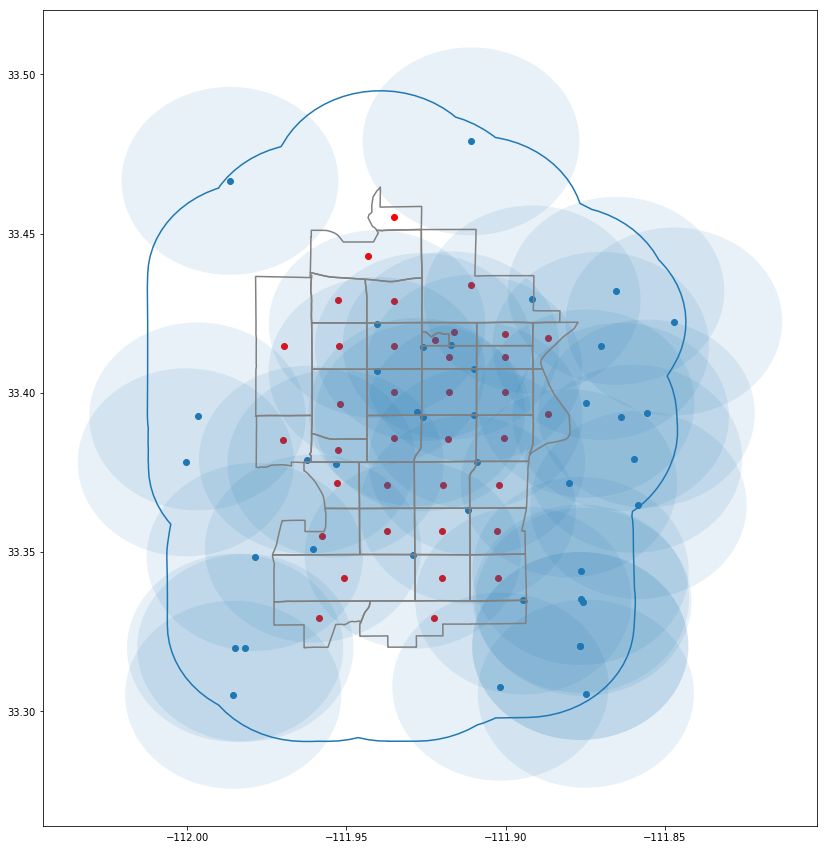

In [500]:
fig, ax = plt.subplots(figsize=(15,15))
bndryConvertedB.boundary.plot(ax=ax)
#bdry.boundary.plot(ax=ax, color='black')
tempe.boundary.plot(ax=ax,color='grey')
tempe.centroid.plot(ax=ax, color='red')
nalConvertedB.plot(ax=ax,alpha=0.1)
nal_2mi.plot(ax=ax)
print(len(nal_2mi))

In [501]:
medFacCendf['NaloxoneDistribCount2mi'] = counting_facilities(nalConvertedB)

medFacCendf.head()

{'3188': 3, '3191.01': 9, '3189': 3, '3190': 7, '3194.03': 8, '3197.03': 4, '3194.04': 9, '3195': 9, '3197.04': 2, '3196': 9, '3191.03': 9, '3191.04': 9, '3192.01': 6, '3192.02': 9, '3197.05': 7, '3197.06': 5, '3201': 1, '8100': 4, '8101': 3, '3198': 7, '3199.02': 8, '3199.03': 6, '3199.04': 4, '3199.05': 3, '3199.06': 6, '3199.10': 3, '3200.01': 5, '3199.08': 4, '3199.09': 6, '3200.07': 3, '3184': 5, '3187': 4, '3193': 6, '3194.01': 8, '3194.02': 8, '3199.07': 3, '3185.01': 0}


TempeTracts_Name  MedFacilitiesCount2mi  PharmCount2mi  DrugDropCount2mi  \
0             3188                     16             11                 2   
1          3191.01                     16             14                 4   
2             3189                     19             16                 2   
3             3190                     16             17                 3   
4          3194.03                     41             20                 2   

   NaloxoneDistribCount2mi                                           geometry  
0                        3  POLYGON ((-111.96132 33.43719, -111.96132 33.4...  
1                        9  POLYGON ((-111.92629 33.41915, -111.92611 33.4...  
2                        3  POLYGON ((-111.96090 33.42195, -111.95857 33.4...  
3                        7  POLYGON ((-111.94358 33.41505, -111.94357 33.4...  
4                        8  POLYGON ((-111.90912 33.39411, -111.90912 33.3...

In [491]:
medFacCendf['geometry'] = tempe['geometry']

In [502]:
with open('DataFiles/countMedicalFacilitiesWithin2milesTempeByTract.pkl', 'wb') as pkl_file:
    pkl.dump(medFacCendf, pkl_file)

medFacCendf.to_csv(r'DataFiles/cntMedicalFacilitiesWithin2milesTempeByTract.csv')

In [290]:
markers = ['o',
          'v',
          '^',
          '<',
          '>',
          's',
          '*',
          'P',
           'D',
          'X']

casesh = list(hospitals_2mi['Category'])

casesh = list(np.unique(casesh))

casesl = list(longterm_2mi['Category'])
casesl = list(np.unique(casesl))

casesm = list(med_2mi['Category'])
casesm = list(np.unique(casesm))

casesd = list(dui_2mi['Category'])
casesd = list(np.unique(casesd))

casesp = list(pharm_2mi['Subtype'])
casesp = list(np.unique(casesp))

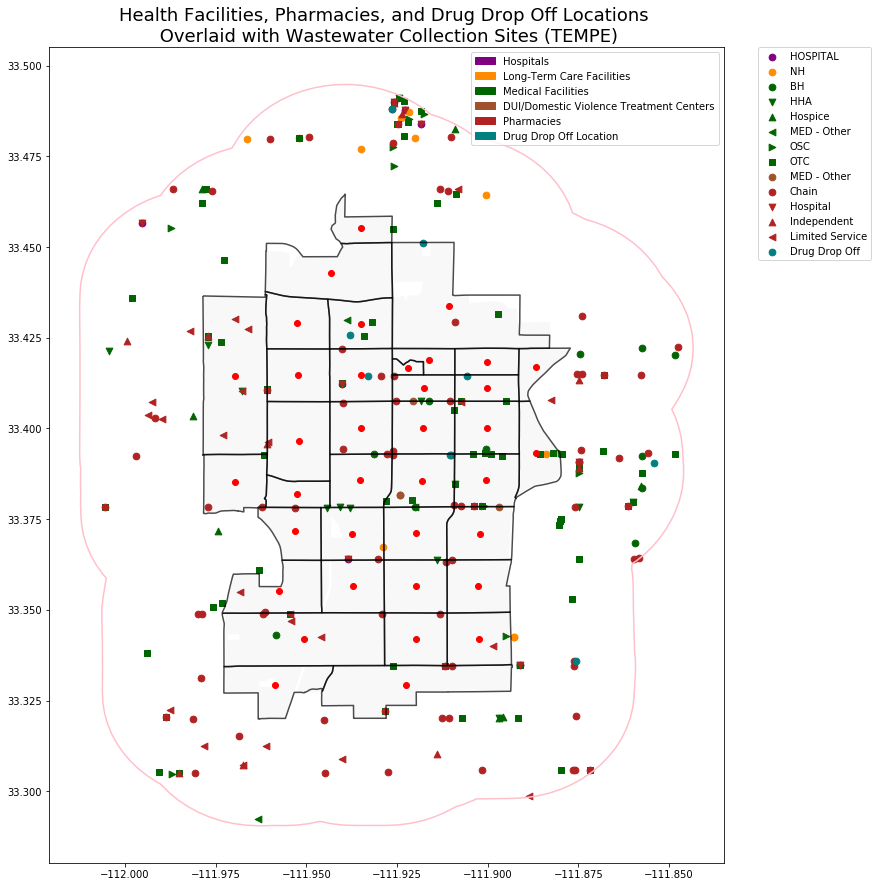

In [296]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Health Facilities, Pharmacies, and Drug Drop Off Locations \n Overlaid with Wastewater Collection Sites (TEMPE)', size = 18)

for i in range(len(casesh)):
    hospitals_2mi[hospitals_2mi['Category']==casesh[i]].plot(ax=ax, marker=markers[i],markersize=45, label=str(casesh[i]),
                                             color='purple')

for i in range(len(casesl)):
    longterm_2mi[longterm_2mi['Category']==casesl[i]].plot(ax=ax, marker=markers[i],markersize=45, label=str(casesl[i]),
                                             color='darkorange')
                                             
for i in range(len(casesm)):
    med_2mi[med_2mi['Category']==casesm[i]].plot(ax=ax, marker=markers[i],markersize=45, label=str(casesm[i]),
                                             color='darkgreen')

    
for i in range(len(casesd)):
    dui_2mi[dui_2mi['Category']==casesd[i]].plot(ax=ax, marker=markers[i],markersize=45, label=str(casesd[i]),
                                             color='sienna')

for i in range(len(casesp)):
    pharm_2mi[pharm_2mi['Subtype']==casesp[i]].plot(ax=ax, marker=markers[i],markersize=45, label=str(casesp[i]),
                                             color='firebrick')

drug_2mi.plot(ax=ax,markersize=45, label="Drug Drop Off",color='teal')

leg1 = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#colors for color legend
h = mpatches.Patch(color='purple',label='Hospitals')
lt = mpatches.Patch(color='darkorange',label = 'Long-Term Care Facilities')
mf = mpatches.Patch(color='darkgreen',label = 'Medical Facilities')
dui = mpatches.Patch(color = 'sienna',label = 'DUI/Domestic Violence Treatment Centers')
p = mpatches.Patch(color='firebrick',label = 'Pharmacies')
dd = mpatches.Patch(color='teal',label = 'Drug Drop Off Location')
l2 = plt.legend(handles=[h,lt,mf,dui,p,dd],loc='upper right')

ax.add_artist(leg1)



bndryConvertedB.boundary.plot(ax=ax, color='pink')
bdry.plot(ax=ax, color='grey',alpha=0.05)
tempe.boundary.plot(ax=ax, color='black',alpha=0.7)
tempe.centroid.plot(ax=ax, color='red',label='Centroid')
plt.savefig('HealthFacilitiesPharmaciesDrugDropMap2mile.png')